In [1]:
import os
import geopandas as gpd

import numpy as np
import pandas as pd

from shapely.geometry import LineString, Point

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
geos_fldr = os.path.join('..', '..', '..', 'Data', 'geos')

districts_shapefile = os.path.join(geos_fldr, 'districts', 'Districts.shp')
sdistricts_shapefile = os.path.join(geos_fldr, 'districts', 'SuperDistricts.shp')

tracts_shapefile = os.path.join(geos_fldr, 'tracts', 'tl_2016_Chattanooga_tracts.shp')

In [3]:
dist_gpd = gpd.read_file(districts_shapefile)
sdist_gpd = gpd.read_file(sdistricts_shapefile)

trct_gpd = gpd.read_file(tracts_shapefile)

In [4]:
print(dist_gpd.columns)
print(sdist_gpd.columns)
print(trct_gpd.columns)

Index(['DISTR_ID', 'SDISTR', 'geometry'], dtype='object')
Index(['SDISTR_ID', 'SUM_SHAPE_', 'FIRST_STAT', 'FIRST_COUN', 'MEAN_Exter',
       'geometry'],
      dtype='object')
Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'MPO',
       'DISTR_ID', 'geometry'],
      dtype='object')


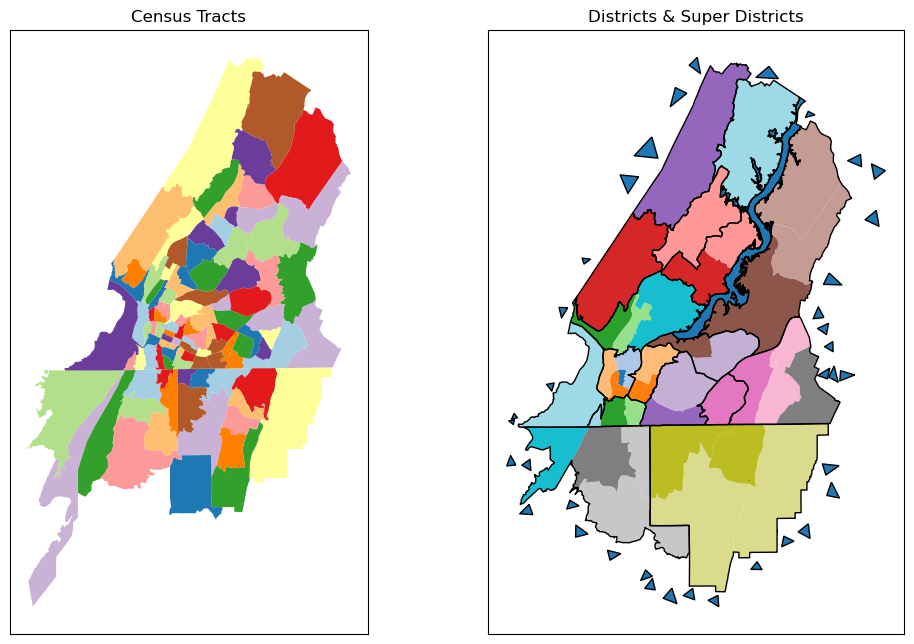

In [5]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

fig, (ax1, ax2) = plt.subplots(1, 2)

trct_gpd.plot(ax=ax1, cmap = cm.get_cmap('Paired'))

dist_gpd.plot(column='DISTR_ID', ax=ax2, cmap=cm.get_cmap('tab20'))
sdist_gpd.plot(ax=ax2, fc='none', ec='k', lw=1)

for ax, title in zip((ax1, ax2), ('Census Tracts', 'Districts & Super Districts')):
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(title)

plt.show()

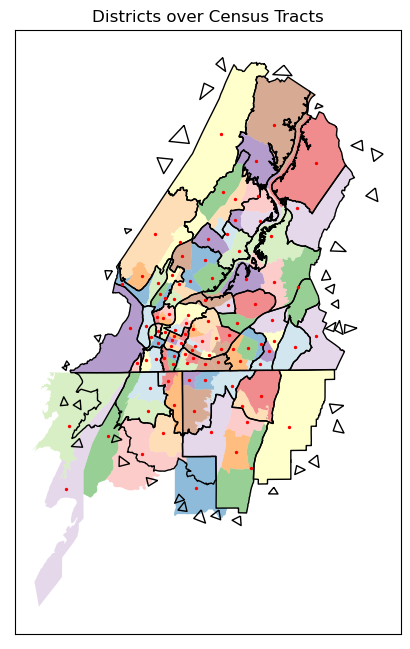

In [6]:
trct_gpd = trct_gpd.to_crs(crs="EPSG:4326")
dist_gpd = dist_gpd.to_crs(crs="EPSG:4326")

tract_centroid = trct_gpd[['GEOID', 'geometry']].copy()
#tract_centroid.drop(['DISTR_ID'], inplace=True, axis=1)

tract_centroid = tract_centroid.to_crs(crs="EPSG:4326")
tract_centroid['geometry'] = tract_centroid['geometry'].representative_point()

fig = plt.figure (figsize = (8, 8))
ax1 = fig.add_subplot(1, 1, 1)

trct_gpd.plot(ax=ax1, cmap = cm.get_cmap('Paired'), alpha=0.5)
dist_gpd.plot(ax=ax1, fc='none', ec='k', lw=1)
tract_centroid.plot(ax=ax1, color='r', markersize=2)

ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)

ax1.set_title("Districts over Census Tracts")
    
plt.show()

C:\Users\yerra\Anaconda3\envs\chattanooga\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  
C:\Users\yerra\Anaconda3\envs\chattanooga\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\yerra\Anaconda3\envs\chattanooga\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


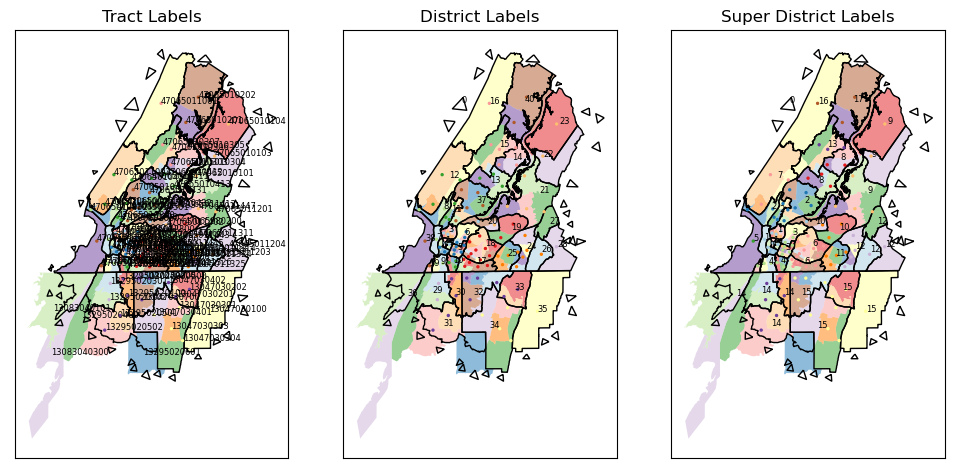

In [10]:
trct_with_dists = gpd.sjoin(tract_centroid, dist_gpd, how='left', op='within')
trct_with_dists[trct_with_dists['DISTR_ID'].isna()]

fig = plt.figure (figsize = (12, 8))
ax1, ax2, ax3 = fig.subplots(1, 3)


trct_gpd.plot(ax=ax1, cmap = cm.get_cmap('Paired'), alpha=0.5)
dist_gpd.plot(ax=ax1, fc='none', ec='k', lw=1)
trct_with_dists.plot(ax=ax1, column='DISTR_ID', cmap = cm.get_cmap('Paired'), markersize=2)

for idx, row in trct_with_dists.iterrows():
    if row['DISTR_ID']:
        ax1.annotate(s=row['GEOID'], xy=row['geometry'].coords[0], fontsize=6, color='k')

for ax, colname in [(ax2, 'DISTR_ID'), (ax3, 'SDISTR')]:
    trct_gpd.plot(ax=ax, cmap = cm.get_cmap('Paired'), alpha=0.5)
    dist_gpd.plot(ax=ax, fc='none', ec='k', lw=1)
    trct_with_dists.plot(ax=ax, column=colname, cmap = cm.get_cmap('Paired'), markersize=2)
    for idx, row in dist_gpd.iterrows():
        ax.annotate(s=row[colname], xy=row['geometry'].representative_point().coords[0], fontsize=6)

for ax, ttle in zip([ax1, ax2, ax3], ['Tract Labels', 'District Labels', 'Super District Labels']):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(ttle)

    
plt.show()

In [11]:
trct_with_dists[trct_with_dists['DISTR_ID'].isna()]

,GEOID,geometry,index_right,DISTR_ID,SDISTR
1,13295020601,POINT (-85.24041 34.80603),NaN,NaN,NaN
3,13295020400,POINT (-85.40513 34.88620),NaN,NaN,NaN
14,13083040101,POINT (-85.47731 34.90170),NaN,NaN,NaN
20,13083040300,POINT (-85.48286 34.80490),NaN,NaN,NaN


In [12]:
# From above figure, built manually map the four tracts that didn't get mapped during sjoin opertation
manual_map = {
    '13295020601': {'DISTR_ID': 31, 'SDISTR': 14},
    '13295020400': {'DISTR_ID': 29, 'SDISTR': 14},
    '13083040101': {'DISTR_ID': 36, 'SDISTR': 14},
    '13083040300': {'DISTR_ID': 36, 'SDISTR': 14},
}

def get_new_dist(x, dist='DISTR_ID'):
        
    if x[dist] == x[dist]: # (NaN == NaN) is False
        return x[dist]        
    else:
        return manual_map[x['GEOID']][dist]


trct_with_dists['DISTR_ID'] = trct_with_dists[['DISTR_ID', 'GEOID']].apply(lambda x: get_new_dist(x), axis=1)
trct_with_dists['SDISTR'] = trct_with_dists[['SDISTR', 'GEOID']].apply(lambda x: get_new_dist(x, 'SDISTR'), axis=1)
trct_with_dists

,GEOID,geometry,index_right,DISTR_ID,SDISTR
0,13295020301,POINT (-85.32666 34.95991),29.0,29.0,14.0
1,13295020601,POINT (-85.24041 34.80603),NaN,31.0,14.0
2,13295020302,POINT (-85.32986 34.92473),29.0,29.0,14.0
3,13295020400,POINT (-85.40513 34.88620),NaN,29.0,14.0
4,13295020502,POINT (-85.34144 34.85886),31.0,31.0,14.0
...,...,...,...,...,...
98,47065012400,POINT (-85.29739 35.04467),2.0,2.0,1.0
99,47065010800,POINT (-85.30748 35.10317),11.0,11.0,2.0
100,47065011447,POINT (-85.09358 35.12166),21.0,21.0,9.0
101,47065980200,POINT (-85.12909 35.08845),19.0,19.0,10.0


In [13]:
trct_gpd.head(5)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,MPO,DISTR_ID,geometry
0,13,295,020301,13295020301,203.01,Census Tract 203.01,G5020,S,24474835,0,+34.9603529,-085.3258801,1,None,"POLYGON ((-85.36879 34.94553, -85.36745 34.946..."
1,13,295,020601,13295020601,206.01,Census Tract 206.01,G5020,S,68898471,112397,+34.8133935,-085.2380453,1,None,"POLYGON ((-85.28070 34.76559, -85.28067 34.765..."
2,13,295,020302,13295020302,203.02,Census Tract 203.02,G5020,S,24465856,0,+34.9249867,-085.3349449,1,None,"POLYGON ((-85.37952 34.90402, -85.37911 34.905..."
3,13,295,020400,13295020400,204,Census Tract 204,G5020,S,67057806,20972,+34.8755088,-085.4066127,1,None,"POLYGON ((-85.45057 34.81788, -85.45057 34.821..."
4,13,295,020502,13295020502,205.02,Census Tract 205.02,G5020,S,85593690,75196,+34.8527550,-085.3420753,1,None,"POLYGON ((-85.40957 34.81796, -85.40891 34.819..."


In [14]:
trct_gpd_new = trct_gpd.drop(columns=['DISTR_ID']).copy()

trct_gpd_new = pd.merge(
    left = trct_gpd_new, 
    right = trct_with_dists[['GEOID', 'DISTR_ID', 'SDISTR']],
    how='left',
    left_on='GEOID',
    right_on='GEOID'
)

In [15]:
trct_gpd_new.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,MPO,geometry,DISTR_ID,SDISTR
0,13,295,020301,13295020301,203.01,Census Tract 203.01,G5020,S,24474835,0,+34.9603529,-085.3258801,1,"POLYGON ((-85.36879 34.94553, -85.36745 34.946...",29.0,14.0
1,13,295,020601,13295020601,206.01,Census Tract 206.01,G5020,S,68898471,112397,+34.8133935,-085.2380453,1,"POLYGON ((-85.28070 34.76559, -85.28067 34.765...",31.0,14.0
2,13,295,020302,13295020302,203.02,Census Tract 203.02,G5020,S,24465856,0,+34.9249867,-085.3349449,1,"POLYGON ((-85.37952 34.90402, -85.37911 34.905...",29.0,14.0
3,13,295,020400,13295020400,204,Census Tract 204,G5020,S,67057806,20972,+34.8755088,-085.4066127,1,"POLYGON ((-85.45057 34.81788, -85.45057 34.821...",29.0,14.0
4,13,295,020502,13295020502,205.02,Census Tract 205.02,G5020,S,85593690,75196,+34.8527550,-085.3420753,1,"POLYGON ((-85.40957 34.81796, -85.40891 34.819...",31.0,14.0


C:\Users\yerra\Anaconda3\envs\chattanooga\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  if __name__ == '__main__':
C:\Users\yerra\Anaconda3\envs\chattanooga\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  app.launch_new_instance()


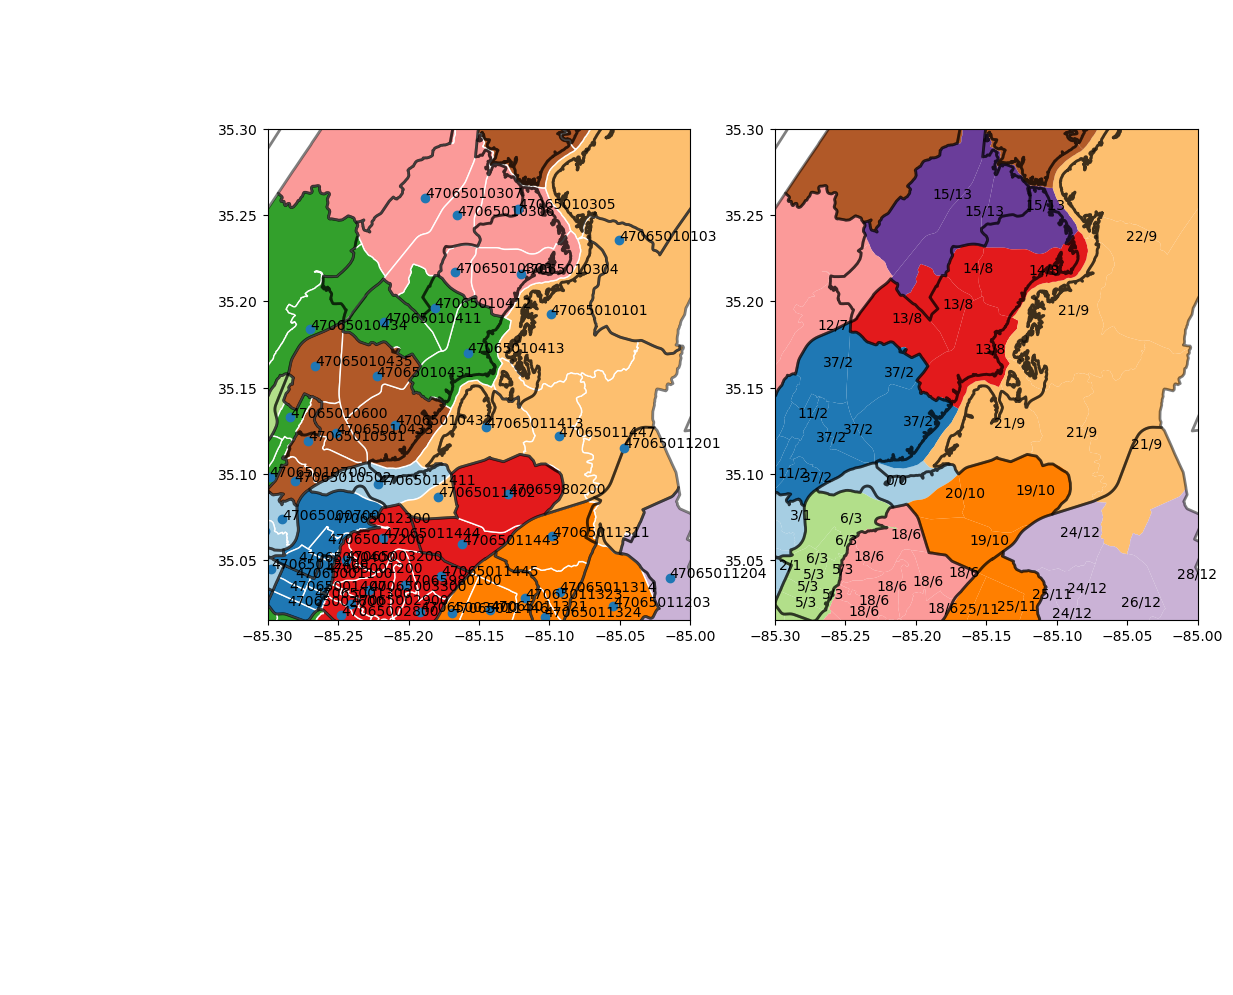

In [16]:
fig = plt.figure (figsize = (12, 8))
ax1, ax2 = fig.subplots(1, 2)


trct_gpd_new.plot(ax=ax1, column='DISTR_ID', cmap = cm.get_cmap('Paired'), ec="w")
dist_gpd.plot(ax=ax1, fc='none', ec='k', lw=2, alpha=0.5)
tract_centroid.plot(ax=ax1)
for idx, row in trct_gpd_new.iterrows():
    ax1.annotate(s=row['GEOID'], xy=row['geometry'].representative_point().coords[0], fontsize=10, color='k')

trct_gpd_new.plot(ax=ax2, column=colname, cmap = cm.get_cmap('Paired'))
sdist_gpd.plot(ax=ax2, fc='none', ec='k', lw=2, alpha=0.5)
for idx, row in trct_gpd_new.iterrows():
    ax2.annotate(s="{:.0f}/{:.0f}".format(row['DISTR_ID'], row['SDISTR']),
                 xy=row['geometry'].representative_point().coords[0],
                 fontsize=10, color='k')

#for ax in [ax1, ax2]:
#    ax.xaxis.set_visible(False)
#    ax.yaxis.set_visible(False)

ax1.set_xlim(-85.3, -85.0)
ax1.set_ylim(35.015, 35.3)

ax2.set_xlim(-85.3, -85.0)
ax2.set_ylim(35.015, 35.3)


plt.show()

In [17]:
# From above figure, built manually map the four tracts that didn't get mapped during sjoin opertation
additional_manual_map = {
    '47065010305': {'DISTR_ID': 14, 'SDISTR': 8},
    '47065011201': {'DISTR_ID': 28, 'SDISTR': 12},
    '47065011411': {'DISTR_ID': 20, 'SDISTR': 10},
}

def additional_get_new_dist(x, dist='DISTR_ID'):
        
    if x['GEOID'] in list(additional_manual_map.keys()): # (NaN == NaN) is False
        return additional_manual_map[x['GEOID']][dist]        
    else:
        return x[dist]


trct_gpd_new['DISTR_ID'] = trct_gpd_new[['DISTR_ID', 'GEOID']].apply(lambda x: additional_get_new_dist(x), axis=1)
trct_gpd_new['SDISTR'] = trct_gpd_new[['SDISTR', 'GEOID']].apply(lambda x: additional_get_new_dist(x, 'SDISTR'), axis=1)
trct_gpd_new.head(5)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,MPO,geometry,DISTR_ID,SDISTR
0,13,295,020301,13295020301,203.01,Census Tract 203.01,G5020,S,24474835,0,+34.9603529,-085.3258801,1,"POLYGON ((-85.36879 34.94553, -85.36745 34.946...",29.0,14.0
1,13,295,020601,13295020601,206.01,Census Tract 206.01,G5020,S,68898471,112397,+34.8133935,-085.2380453,1,"POLYGON ((-85.28070 34.76559, -85.28067 34.765...",31.0,14.0
2,13,295,020302,13295020302,203.02,Census Tract 203.02,G5020,S,24465856,0,+34.9249867,-085.3349449,1,"POLYGON ((-85.37952 34.90402, -85.37911 34.905...",29.0,14.0
3,13,295,020400,13295020400,204,Census Tract 204,G5020,S,67057806,20972,+34.8755088,-085.4066127,1,"POLYGON ((-85.45057 34.81788, -85.45057 34.821...",29.0,14.0
4,13,295,020502,13295020502,205.02,Census Tract 205.02,G5020,S,85593690,75196,+34.8527550,-085.3420753,1,"POLYGON ((-85.40957 34.81796, -85.40891 34.819...",31.0,14.0


In [18]:
trct_gpd_new[trct_gpd_new['GEOID'].isin(additional_manual_map.keys())]

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,MPO,geometry,DISTR_ID,SDISTR
23,47,065,011411,47065011411,114.11,Census Tract 114.11,G5020,S,12264968,3031800,+35.0958357,-085.2149270,1,"POLYGON ((-85.27004 35.09113, -85.26977 35.091...",20.0,10.0
40,47,065,010305,47065010305,103.05,Census Tract 103.05,G5020,S,20517235,2894811,+35.2465436,-085.1184840,1,"POLYGON ((-85.15344 35.24163, -85.15343 35.242...",14.0,8.0
51,47,065,011201,47065011201,112.01,Census Tract 112.01,G5020,S,54949635,1181460,+35.1020074,-085.0353556,1,"POLYGON ((-85.08452 35.12704, -85.08450 35.127...",28.0,12.0


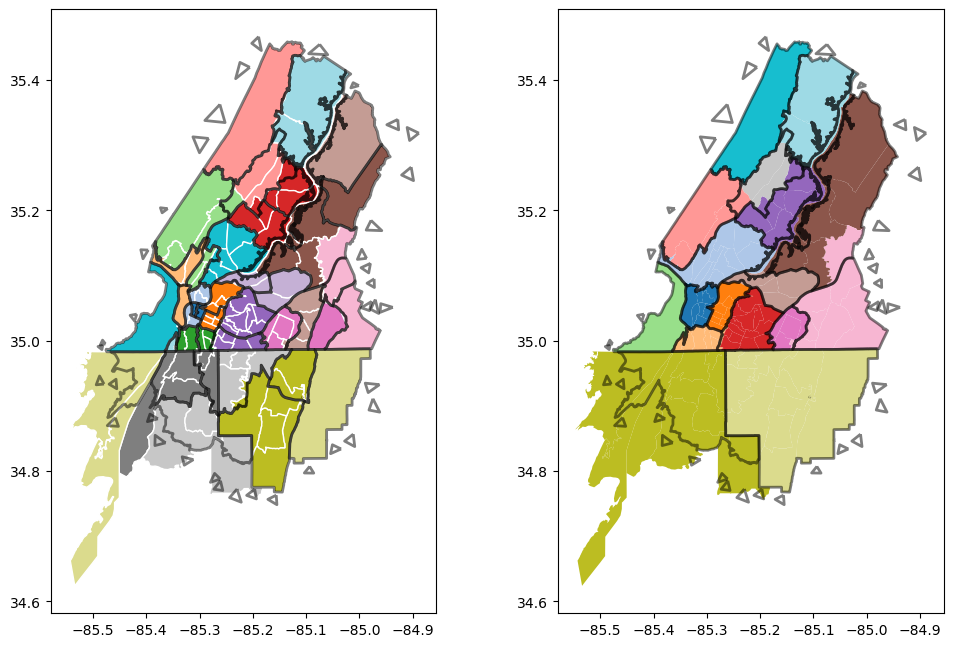

In [19]:
fig = plt.figure (figsize = (12, 8))
ax1, ax2 = fig.subplots(1, 2)


trct_gpd_new.plot(ax=ax1, column='DISTR_ID', cmap = cm.get_cmap('tab20'), ec="w")
dist_gpd.plot(ax=ax1, fc='none', ec='k', lw=2, alpha=0.5)

trct_gpd_new.plot(ax=ax2, column='SDISTR', cmap = cm.get_cmap('tab20'))
sdist_gpd.plot(ax=ax2, fc='none', ec='k', lw=2, alpha=0.5)

plt.show()

In [20]:
save_tracts_wDists_filename = os.path.join(geos_fldr, 'tracts', 'tl_2016_Chattanooga_tracts_wDists.shp')
trct_gpd_new.to_file(save_tracts_wDists_filename)